In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [ ]:
#Aqui va el estudio inicial para ver los datos

In [2]:
# First read the clean initial loon data
raw_df = pd.read_csv('../../../../og_data/extract_clean_with_country.csv', index_col='Unnamed: 0',
                       low_memory=False)

/home/toni/.local/lib/python2.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
# Get a baseline
bl = raw_df.sort_values(by=['ts'])

In [4]:
bl.head()

,craw_ts,flight_id,aircraft_id,lat,lon,azi,alt,speed,ts,country,country_code,trip_id
0,1.468556e+12,HBAL417,BA1102,44.7567,-113.6905,194,62300.0,4,2016-07-15 04:07:57,United States of America,USA,HBAL417-BA1102
1,1.468556e+12,HBAL406,BA1123,43.3738,-113.7937,258,60500.0,5,2016-07-15 04:07:59,United States of America,USA,HBAL406-BA1123
2,1.468556e+12,HBAL427,BA111F,18.2783,-65.7778,258,57600.0,29,2016-07-15 04:07:59,Puerto Rico,PRI,HBAL427-BA111F
3,1.468556e+12,HBAL287,BA1008,-7.2694,-79.8547,356,59900.0,19,2016-07-15 04:08:00,NaN,NaN,HBAL287-BA1008
4,1.468556e+12,HBAL305,BA1007,-7.3076,-78.5334,352,60200.0,16,2016-07-15 04:08:00,Peru,PER,HBAL305-BA1007


In [5]:
# VELOCITY STUDY

In [6]:
# First study the speed by loon
loons_by_avg_speed = bl[['aircraft_id', 'speed']].groupby(by='aircraft_id').mean() \
                                                    .sort_values(by=['speed'], ascending=False)                          
loons_by_top_speed = bl[['aircraft_id', 'speed']].groupby(by='aircraft_id').max()  \
                                                    .sort_values(by=['speed'], ascending=False)

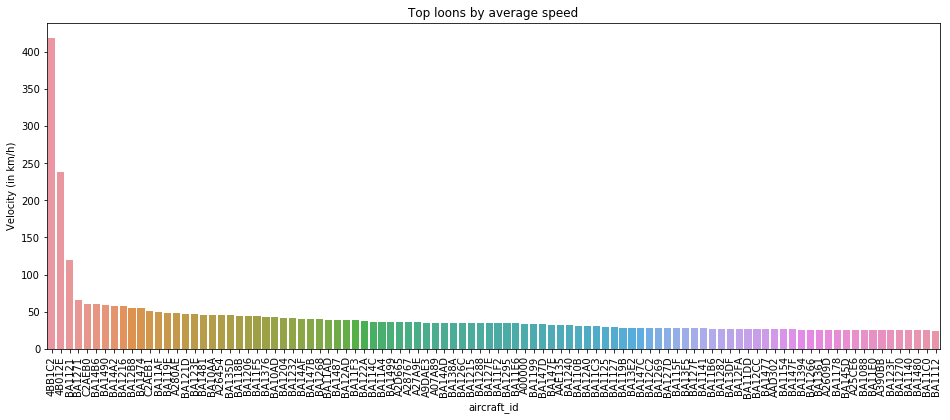

In [18]:
# Plot velocities for loons
plt.figure(figsize=(16,6))
plt.title("Top loons by average speed")

ax = sns.barplot(x=loons_by_avg_speed.head(100).index, y=loons_by_avg_speed.head(100)['speed'])

# Add label for vertical axis
plt.ylabel("Velocity (in km/h)")

b = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

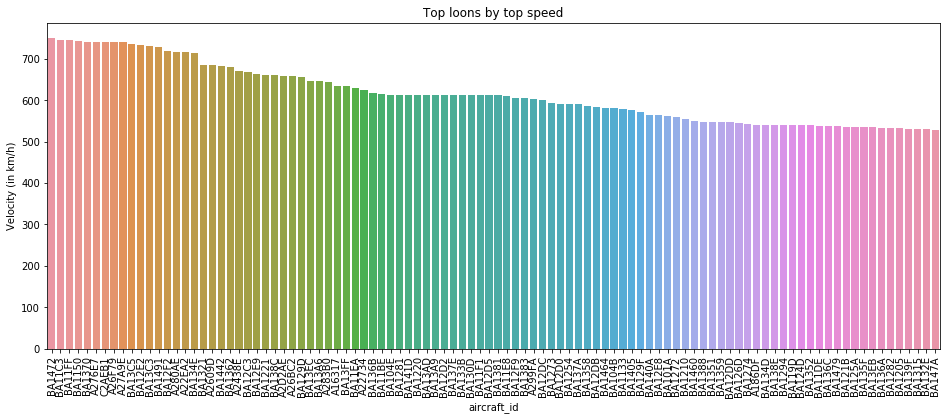

In [19]:
# Plot velocities for loons
plt.figure(figsize=(16,6))
plt.title("Top loons by top speed")

ax = sns.barplot(x=loons_by_top_speed.head(100).index, y=loons_by_top_speed.head(100)['speed'])

# Add label for vertical axis
plt.ylabel("Velocity (in km/h)")

b = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [9]:
# The avg velocity on the first three loons is sensibly higher than the rest. Let's loook at their data
best_avg_loons = loons_by_avg_speed.head(3)
best_avg_loons = best_avg_loons.reset_index()

worst_avg_loons = loons_by_avg_speed.tail(3)
worst_avg_loons = worst_avg_loons.reset_index()

In [10]:
bl.loc[bl.aircraft_id == best_avg_loons.iloc[0].aircraft_id].shape

(3, 12)

In [11]:
bl.loc[bl.aircraft_id == best_avg_loons.iloc[1].aircraft_id].shape

(39, 12)

In [12]:
bl.loc[bl.aircraft_id == best_avg_loons.iloc[2].aircraft_id].shape

(109, 12)

In [13]:
bl.loc[bl.aircraft_id == worst_avg_loons.iloc[0].aircraft_id].shape

(5, 12)

In [14]:
bl.loc[bl.aircraft_id == worst_avg_loons.iloc[1].aircraft_id].shape

(153, 12)

In [15]:
bl.loc[bl.aircraft_id == worst_avg_loons.iloc[2].aircraft_id].shape

(1, 12)

In [16]:
# The data lacks several records so we cannot consider it for the study
# We can observe that the top velocity is steadier but again we cannot trust the data. 
# We should first get reliable data and then study the velocity. 
# We can take a look at the velocity by flight instead of by aircraft
# since we know how to get complete flights from last part (SampleCompleteFlights)

In [17]:
# Second study the speed by flights
# We will use as identifier a combination of flight_id-aircraft_id
trips_by_avg_speed = bl[['trip_id', 'speed']].groupby(by='trip_id').mean() \
                                                    .sort_values(by=['speed'], ascending=False)                          
trips_by_top_speed = bl[['trip_id', 'speed']].groupby(by='trip_id').max()  \
                                                    .sort_values(by=['speed'], ascending=False)

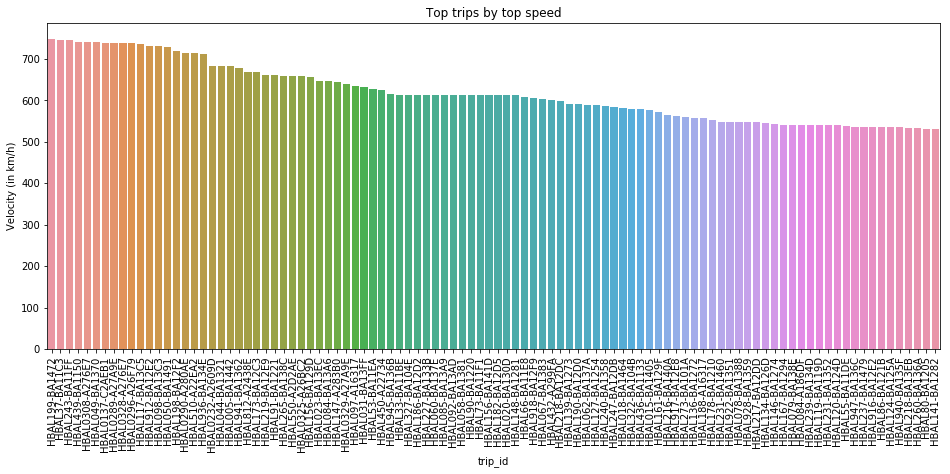

In [20]:
# Plot velocities for loons
plt.figure(figsize=(16,6))
plt.title("Top trips by top speed")

ax = sns.barplot(x=trips_by_top_speed.head(100).index, y=trips_by_top_speed.head(100)['speed'])

# Add label for vertical axis
plt.ylabel("Velocity (in km/h)")

b = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [21]:
# Now we must check which top and last flights are reliable
# Compute the variance of the frequency of the records of a given flight

def compute_ts_frequency_variance(t_id):
    # Get the history of the flight
    trip_records = bl.loc[bl.trip_id == t_id].copy()
    
    # Compute the time since last record in a new column
    trip_records['ts'] = pd.to_datetime(trip_records['ts'])
    trip_records['time_since_last_record'] = trip_records['ts'] - trip_records['ts'].shift()
    trip_records['time_since_last_record'] = trip_records['time_since_last_record'].fillna(0)
    
    # Compute the variance of such column

    return trip_records['time_since_last_record'].std()

In [22]:
candidate_best_avg_trips = trips_by_avg_speed.head(50).reset_index()
best_top_trips = trips_by_top_speed.head(30).reset_index()

candidate_worst_avg_trips = trips_by_avg_speed.tail(50).reset_index()
worst_top_trips = trips_by_top_speed.tail(30).reset_index()

In [23]:
candidate_best_avg_trips['frequency_var'] = candidate_best_avg_trips \
                                            .apply(lambda r: compute_ts_frequency_variance(r['trip_id']), axis=1)
candidate_worst_avg_trips['frequency_var'] = candidate_worst_avg_trips \
                                            .apply(lambda r: compute_ts_frequency_variance(r['trip_id']), axis=1)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  # This is added back by InteractiveShellApp.init_path()


In [24]:
candidate_best_avg_trips = candidate_best_avg_trips.sort_values(by='frequency_var').reset_index(drop=True)
candidate_best_avg_trips.head(15)

,trip_id,speed,frequency_var
0,HBAL044-BA14B6,60.255973,00:00:17.958364
1,HBAL153-A2D665,58.306792,00:00:30.271812
2,HBAL0137-C2AEB1,51.910112,00:00:30.297968
3,HBAL0209-A27A9E,61.897143,00:00:33.215149
4,HBAL0174-A25CE6,88.115044,00:00:33.401486
5,HBAL0155-AAE135,97.854890,00:00:36.690382
6,HBAL213E-A26F79,84.365672,00:00:39.427109
7,HBAL0142-A07A89,89.717949,00:00:44.876017
8,HBAL0183-A26454,91.382353,00:00:44.972501
9,HBAL0225-A26BC2,62.000000,00:00:47.173739


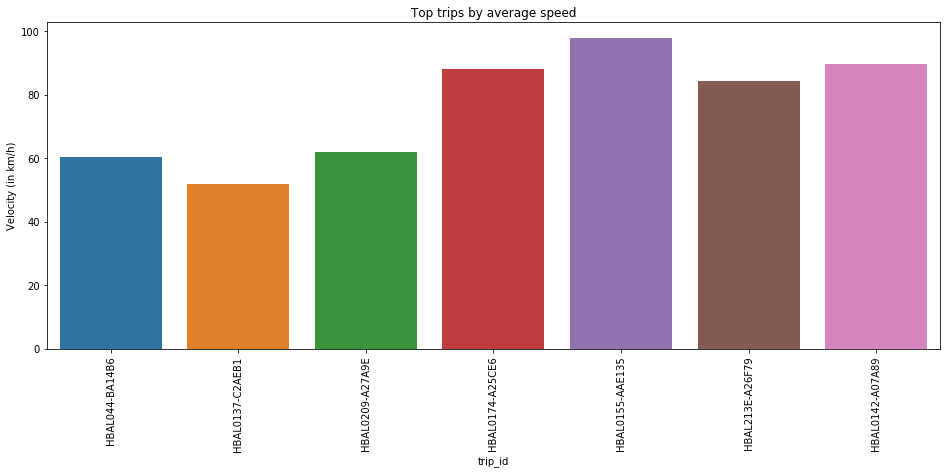

In [26]:
# The first 10 flights look healthy. 
# Taking a look in kepler we can see the ones going up and then going down which shows a complete flight
# Candidates: ['HBAL044-BA14B6', 'HBAL153-A2D665', 'HBAL0137-C2AEB1', 'HBAL0209-A27A9E', 'HBAL0174-A25CE6',
# 'HBAL0155-AAE135', 'HBAL213E-A26F79', 'HBAL0142-A07A89', 'HBAL0183-A26454']

best_avg_trips = candidate_best_avg_trips.loc[candidate_best_avg_trips \
                                        .trip_id \
                                        .isin(['HBAL044-BA14B6', 'HBAL0137-C2AEB1', 'HBAL0209-A27A9E', \
                                               'HBAL0174-A25CE6', 'HBAL0155-AAE135', 'HBAL213E-A26F79', 'HBAL0142-A07A89'])]
# Plot velocities for loons
plt.figure(figsize=(16,6))
plt.title("Top trips by average speed")
ax = sns.barplot(x=best_avg_trips.trip_id, y=best_avg_trips['speed'])

# Add label for vertical axis
plt.ylabel("Velocity (in km/h)")

b = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [31]:
candidate_worst_avg_trips = candidate_worst_avg_trips.sort_values(by='frequency_var').reset_index(drop=True)
candidate_worst_avg_trips.head(10)

,trip_id,speed,frequency_var
0,HBAL0196-A07A89,1.000000,00:00:00
1,HBAL021-BA1472,5.000000,00:00:00
2,HBAL81-BA1211,8.271405,00:00:16.375524
3,HBAL453-BA1142,7.793655,00:00:16.772716
4,HBAL467-BA1174,8.512938,00:00:17.015778
5,HBAL500-A33E06,8.508446,00:00:19.167618
6,HBAL174-BA1419,8.378940,00:00:21.512462
7,HBAL083-BA139D,6.620853,00:00:22.259521
8,HBAL5-BA1151,8.230592,00:00:22.328535
9,HBAL670-A33E06,6.842857,00:00:23.123190


NameError: name 'worst_avg_flights' is not defined

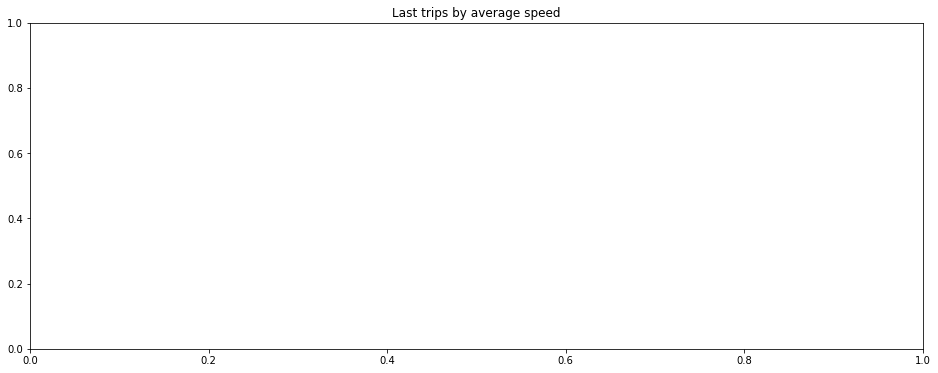

In [33]:
# The first 10 flights look healthy. 
# Taking a look in kepler we can see the ones going up and then going down which shows a complete flight
# Candidates: ['HBAL0196-A07A89', 'HBAL021-BA1472', 'HBAL81-BA1211', 'HBAL453-BA1142', 'HBAL467-BA1174', 'HBAL500-A33E06',
# 'HBAL174-BA1419', 'HBAL083-BA139D', 'HBAL5-BA1151', 'HBAL670-A33E06']

worst_avg_trips = candidate_worst_avg_trips.loc[candidate_worst_avg_trips.trip_id \
                                               .isin(['HBAL0196-A07A89', 'HBAL81-BA1211', 'HBAL453-BA1142', \
                                                      'HBAL467-BA1174', 'HBAL500-A33E06', 'HBAL174-BA1419', \
                                                      'HBAL670-A33E06'])]
# Plot velocities for loons
plt.figure(figsize=(16,6))
plt.title("Last trips by average speed")
ax = sns.barplot(x=worst_avg_flights.trip_id, y=worst_avg_flights['speed'])

# Add label for vertical axis
plt.ylabel("Velocity (in km/h)")

b = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [ ]:
best_top_flights['frequency_var'] = best_top_flights \
                                            .apply(lambda r: compute_ts_frequency_variance(r['flight_id']), axis=1)

In [ ]:
worst_top_flights['frequency_var'] = worst_top_flights \
                                            .apply(lambda r: compute_ts_frequency_variance(r['flight_id']), axis=1)